In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

# Silence warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

---

## Finding duplicate queries

How many users make duplicate queries during a day?

In [2]:
import random

# number of unique queries
X = 1000
# number of duplicate queries
D = 500
# in total a user will have made X + 2*D queries

queries = ['x%i' % i for i in range(X)] + ['d%i' % (i%D) for i in range(2*D)]
print(D/len(queries))
#queries[-100:]

0.25


In [3]:
# let's just sub-sample the queries
sample = [query for query in queries if random.random() < 0.1]
#sample

In [4]:
from collections import Counter

def duplicates(queries):
    counts = Counter(queries)
    dupes = []
    for query,count in counts.items():
        if count > 1:
            dupes.append(query)
    return len(dupes)

duplicates(sample) / len(sample)
# ... something isn't quite right with this

0.02717391304347826

In [5]:
# sample users, not queries
# pick a fraction (say one tenth) of users and collect all their queries
import string

X = 1000
D = 500
U = 50

queries = []

for u in range(U):
    # our users need a name!
    name = ''.join([random.choice(string.ascii_letters) for _ in range(10)])
    queries.extend([(name, 'x%i' % i) for i in range(X)] +
                   [(name, 'd%i' % (i%D)) for i in range(2*D)])

random.shuffle(queries)
queries[:30] # 30 random (user, query) pairs

[('lrmGIISRmA', 'd497'),
 ('ZGFThMiHNP', 'x903'),
 ('efpAluweHB', 'x84'),
 ('EPrklFBRmx', 'd221'),
 ('XbaDOiOaGs', 'x785'),
 ('XrjXlalTJu', 'x711'),
 ('EPrklFBRmx', 'x997'),
 ('xNAkVqXsOW', 'x457'),
 ('wTcJRwiLkK', 'd166'),
 ('mKrjzPooHK', 'x518'),
 ('yuNpPmHKpF', 'x132'),
 ('XrjXlalTJu', 'd308'),
 ('yOtWymhVVq', 'd365'),
 ('KKkBEzdAbI', 'd137'),
 ('JSINVukrib', 'x673'),
 ('yOtWymhVVq', 'x201'),
 ('pRjuDcjBdO', 'd446'),
 ('QdHjVdnOqH', 'd474'),
 ('EmAnwsstOg', 'x825'),
 ('rXbpziXgik', 'd57'),
 ('uzDHVTvovc', 'x224'),
 ('yuNpPmHKpF', 'd71'),
 ('yOtWymhVVq', 'x988'),
 ('efpAluweHB', 'x135'),
 ('VXZYIyDwHq', 'x714'),
 ('EmAnwsstOg', 'x98'),
 ('TUMnufIgnb', 'd99'),
 ('EPrklFBRmx', 'd373'),
 ('igTXuEdoNC', 'x897'),
 ('KKkBEzdAbI', 'd487')]

---

## Hash functions

We need a way to map from a username to some kind of numerical ID.
How do we do this? Especially if we don't know how many users there are? Need a function
that maps arbitrary inputs to a defined range of integers.

In [6]:
from sklearn.utils import murmurhash3_32

# python's builtin hash function isn't even approximately random
def hash_(n, seed=1):
    return murmurhash3_32(n, seed=seed, positive=True)

print(hash_("tim"), hash_("jim"), hash_("fred"), hash_("joe"))

2095282958 2892697151 374763764 1284432482


`hash_(item)` produces a 'random' number between `0` and `2**32-1`.
The output is uniformly distributed between the two limits and the same input will always produce the same output. Designing hash functions could be the topic of a whole lecture ... let's just assume they work and are a piece of magic handed down to us.

We use it as a tool to convert arbitrary objects/values into uniformly distributed 'random' values.

In [7]:
# hash name into ten buckets, pick all users that fall into bucket 1

sample = []
for (user, query) in queries:
    if (hash_(user) % 10) == 0:
        sample.append((user,query))
    
duplicates(sample) / len(sample)

0.25

In [8]:
# the bucket will contain approximately five users
set([x[0] for x in sample])

{'VXZYIyDwHq', 'mKrjzPooHK', 'pRjuDcjBdO', 'yOtWymhVVq'}

---

## Approximate answers

Often approximate answers are plenty good enough. Especially if you can compute a bound on the size of the mistake. And even more so if the alternative is getting no answer because your data is infinite!

Approximate is different from random subsampling:

In [9]:
x = [random.randint(0, 2e9) for _ in range(5000)]

y = [i>>8 for i in x]

In [10]:
# remove the last 8bits from the integers
bin(x[0])

'0b101110100010101101000111'

In [11]:
bin(x[0]>>8), bin(x[0])[:-8]

('0b1011101000101011', '0b1011101000101011')

In [12]:
(x[0], x[0]>>8)

(12200775, 47659)

In [13]:
mean_x = sum(x) / len(x)
mean_y = sum(y) / len(y) * 2**8

# compare the two answers and the fractional difference between the two
print(mean_x, mean_y, 100*(mean_x-mean_y)/mean_x)

986645326.564 986645198.6944 1.296003706852885e-05


---

## Bloom filter

Have I seen this item before? Is this a word? Is there a value for this key in our database? Is this email address in the users addressbook?

In [14]:
from sklearn.utils import check_random_state
from ipythonblocks import BlockGrid

class BloomFilter:
    def __init__(self, n, k, random_state=None):
        # k hash functions and n bits
        self.n = n
        self.bits = np.zeros(n, dtype=bool)
        
        # our k hash functions
        self.rng = check_random_state(random_state)
        r = self.rng.randint(1e9)
        self.k = [r + k for k in range(1, k+1)]

    def add(self, val):
        for i in self.k:
            idx = hash_(val, i) % self.n
            self.bits[idx] = True

    def __contains__(self, val):
        for i in self.k:
            if not self.bits[hash_(val, i) % self.n]:
                return False
            
        return True
    
    def show(self):
        grid = BlockGrid(self.n, 1, fill=(0,0,0))
        for n,v in enumerate(self.bits):
            if v:
                grid[0, n] = (255,0,0)
        return grid.show()

In [15]:
# my laptop doesn't have that much memory :( so use 1e4 instead of 1e9
B = int(8e1)
S = int(1e1)

b = BloomFilter(B, 1)
b.show()

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [16]:
for _ in range(S):
    r = np.random.randint(2**31 - 1)
    b.add(r)
    
b.show()

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [17]:
# with more hash functions
b = BloomFilter(B, 4)
for _ in range(S):
    r = np.random.randint(2**31 - 1)
    b.add(r)
    
b.show()

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


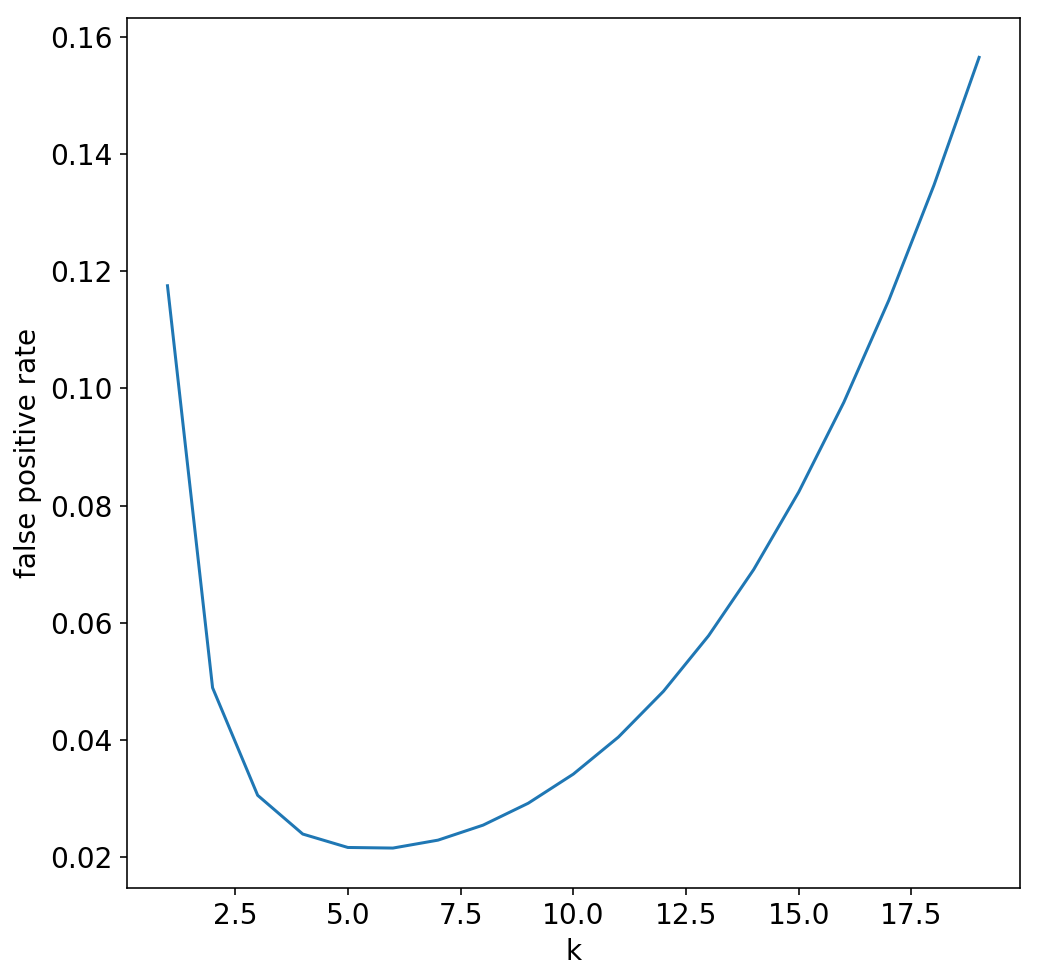

In [18]:
# optimal k?
k = np.array(range(1, 20))
plt.plot(k, (1-np.exp(-(k*S)/B))**k)
plt.xlabel("k")
plt.ylabel("false positive rate");

---

## Aside -- Genomics

A brief, incomplete and potentially incorrect aside on genome assembly.

A genome is a very, very, very long string using one of A, C, G or T as characters: "ACGTAGTTGGTAAGATAT...". The process of capturing a real world genome as machine-readable data is called sequencing. It works a bit likes this:

* create many copies of the genome,
* break each copy up into small chunks (called reads),
* convert each read into a string in a text file

The analogy is: photocopy a book many times, then shred every page, scan in each shred.

Now the fun starts: trying to put the shreds back together.

(In reality people have moved on from doing this for single genomes, it is all about sequencing random bits of dirt containing many different genomes. Analogy: photocopy every book in a library, shred, mix them together, now try to reconstruct each of the books.)

In [19]:
def generate_genome(N=1000):
    g = []
    for i in range(N):
        g.append(random.choice("ACGT"))
    return ''.join(g)

generate_genome()

'GCTTGCCTCTGCTTCGCCTGGGCCCCCGTCCACGTAAACTCTTAAATTGACACCCATGATACGGACGAATGCCTGCAATATCTCCTATCCTCTATTTCTTAAGTCGTCTTTTTGCTGACGGAGCATAGTCTAGCCCAATGGTATCATAGTCTTCCATTCATGTGTTAAGAGAATCTTTTTAGGCACATTGGCCTGACTCCGGCTTAAGTTCGGGCGCTAAGTGTAACATCCACACATGGCAGCTTGGTTGGACGGATTGACTAGACCTGGTGCTACAGGCTCGCCGGATGGTCAATCGGTCTTTACTACTGGTAACTCATATCCTGTCGTACTAAAGCAGTGAACCCCATAAGCGAGCAAGGTGGTTGACCGGCCCTTGACGCTCATCTTAGCCAGCGATCCATCCGAAACGAACGTGACGCTACCTGACAATGACGGGGGCCATGATAAGCTACAATTTTGTAAATGTAATGACATAGTTCGCAACACACCACTAAAGCTATTTCGGTTATTTATGGGAGAACGTTGCGCACATATACGTTGTTTGCGAGTAATGTAACAGGGATGAAGCGATACCGGGAGTAAGTAGCGACGTGTGCAAGCGATAGGAGTCCGTAGATGTATCAGTCCGGAAGACACTAAGCTTGGCGAACGCCGCTGCTCCTCCTGGGCGAGTTACCGCATTGTTTGAAATGGAAAACGACATAGCCGGGGGGTAGACACTCAGTGAGATACGATATTTAGTCGTTTGAGTTGCCACGTTAAGTATCTACTGCCGCCCGATTAAGCCCTGACATGATAAGCGATTACTTTTACTACAAGCCCCCAAAGCGCGGCACCATTTCCACTTGTTTCTGAACCAGCTCAGATGAGTGCCATACTAATTGTTAATCGTGATCACCCTAGGGACTCGTGGTAACCCAGTCACAACGGATCGTAGGAAGAGGCTTCGGACAAACTCGGGTTGTACTCATACTCGAAGACAGATCACTTGTACGA

In [20]:
def make_reads(genome, read_length=100, depth=30):
    reads = []
    # want to cover every part of the genome roughly `depth` times
    n_reads = depth * (len(genome) // read_length)
    for d in range(n_reads):
        ix = random.randint(0, len(genome)-read_length)
        reads.append(genome[ix:ix+read_length])
        
    return reads

reads = make_reads(generate_genome())
reads

['CAACATCCAACAAACGTGAACATTGTGGTTATGGCTCTTTCTGTCTCGCAAGGAGGAATATCCTAACAGATGCAGTACACCGTACGATTTTCCGGCTAAT',
 'TCCTCTCACTCATTAGTACCTAGGAAGGATCGGTATACGGAATGTCGTCCGAAAGTTGCCCACCACGGTGGCGAGGTGATGATCAAGAATTCATGCGCCC',
 'CGCCTTACCTGTTGGGTAACAGTTGGCAACGATCATTACTGAGGTCGTTATGGCGTCAACACGATGTCAGAACCCTTACCACTCGTGATAGACATTAAAG',
 'TCATTACTGAGGTCGTTATGGCGTCAACACGATGTCAGAACCCTTACCACTCGTGATAGACATTAAAGTCATGACACAGTTCCTCTCACTCATTAGTACC',
 'CGTGCGTTCTGGCAAGGGAGTCTAAAAGCGACCGAGTGGCGCTTTGATGTTAGAGAGGTCAATGTCCCAGTACTGCGGGATCTCGGATATTGTTGAGCCT',
 'TGAGAGGATAATTGTCAGAAAACCTGCCACATACGAGCCTCAACATCCAACAAACGTGAACATTGTGGTTATGGCTCTTTCTGTCTCGCAAGGAGGAATA',
 'AGCCTAGATTCGTGCCTCATTCGTGGCCACTGCGTGGACATCTTAAAGTGAAGGACACGTACCTACAACGCTTGGTAACACGTGGTTTAAGATATGCACT',
 'GCGTTTAGCATAGCTTCCTGTAGGGCACATGACTGCCGGGATTACGACTAGCCGTATTTGAGAGTAATATAGACACTATGGAAGCGTCCACTTTGCAATC',
 'AAACGTGAACATTGTGGTTATGGCTCTTTCTGTCTCGCAAGGAGGAATATCCTAACAGATGCAGTACACCGTACGATTTTCCGGCTAATGAATAACCAAG',
 'ACCAGAAGCCTAGATTCGTGCCTCATTCGTGGCCACTGCGTGGACATCTTAAA

In [21]:
def kmers(reads, k=21):
    if isinstance(reads, str):
        reads = [reads]
    for read in reads:
        for i in range(len(read) - k + 1):
            yield read[i:i+k]

In [22]:
print(reads[0])
print()
print("The read's kmers:\n", list(kmers(reads[0])))

CAACATCCAACAAACGTGAACATTGTGGTTATGGCTCTTTCTGTCTCGCAAGGAGGAATATCCTAACAGATGCAGTACACCGTACGATTTTCCGGCTAAT

The read's kmers:
 ['CAACATCCAACAAACGTGAAC', 'AACATCCAACAAACGTGAACA', 'ACATCCAACAAACGTGAACAT', 'CATCCAACAAACGTGAACATT', 'ATCCAACAAACGTGAACATTG', 'TCCAACAAACGTGAACATTGT', 'CCAACAAACGTGAACATTGTG', 'CAACAAACGTGAACATTGTGG', 'AACAAACGTGAACATTGTGGT', 'ACAAACGTGAACATTGTGGTT', 'CAAACGTGAACATTGTGGTTA', 'AAACGTGAACATTGTGGTTAT', 'AACGTGAACATTGTGGTTATG', 'ACGTGAACATTGTGGTTATGG', 'CGTGAACATTGTGGTTATGGC', 'GTGAACATTGTGGTTATGGCT', 'TGAACATTGTGGTTATGGCTC', 'GAACATTGTGGTTATGGCTCT', 'AACATTGTGGTTATGGCTCTT', 'ACATTGTGGTTATGGCTCTTT', 'CATTGTGGTTATGGCTCTTTC', 'ATTGTGGTTATGGCTCTTTCT', 'TTGTGGTTATGGCTCTTTCTG', 'TGTGGTTATGGCTCTTTCTGT', 'GTGGTTATGGCTCTTTCTGTC', 'TGGTTATGGCTCTTTCTGTCT', 'GGTTATGGCTCTTTCTGTCTC', 'GTTATGGCTCTTTCTGTCTCG', 'TTATGGCTCTTTCTGTCTCGC', 'TATGGCTCTTTCTGTCTCGCA', 'ATGGCTCTTTCTGTCTCGCAA', 'TGGCTCTTTCTGTCTCGCAAG', 'GGCTCTTTCTGTCTCGCAAGG', 'GCTCTTTCTGTCTCGCAAGGA', 'CTCTTTCTGTCTCGCAAGGAG', 'TC

In [23]:
counts = Counter(kmers(reads))

In [24]:
# for every kmer we have counted how often it appears in all the reads
counts[list(counts.keys())[0]]

22

In [25]:
# In reality the sequencing process makes mistakes
def mutate(reads, error_rate=0.01):
    for read in reads:
        new_read = []
        for base in read:
            if random.random() < error_rate:
                base = random.choice("ACGT".replace(base, ""))
                
            new_read.append(base)
        yield ''.join(new_read)

In [26]:
reads_with_errors = list(mutate(reads, error_rate=0.01))
counts_with_errors = Counter(kmers(reads_with_errors))

# single base errors dramatically increase the number of unique kmers
print(len(set(kmers(reads))), len(set(kmers(reads_with_errors))))

975 5362


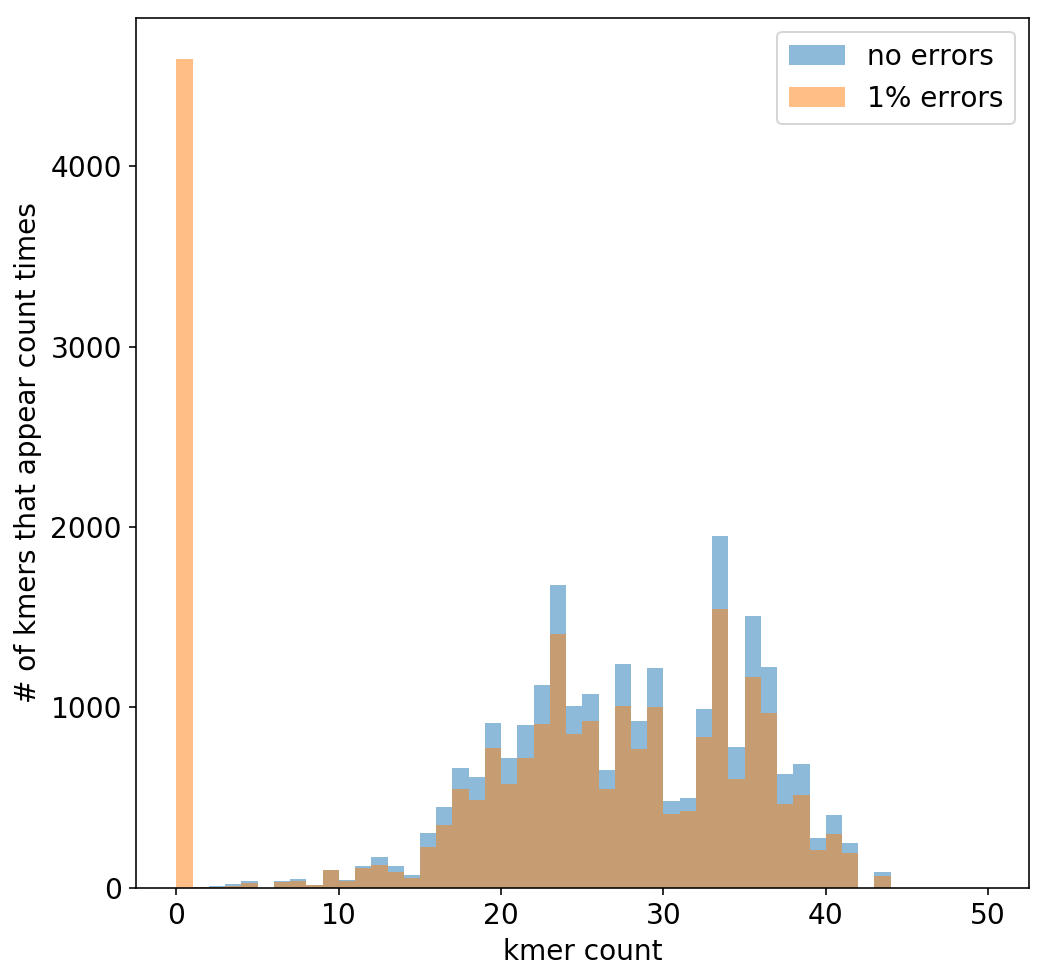

In [27]:
plt.hist([counts[kmer] for kmer in kmers(reads)],
         range=(0,50), bins=50, label='no errors',
         alpha=0.5)
plt.hist([counts[kmer] for kmer in kmers(reads_with_errors)],
         range=(0,50), bins=50, label='1% errors',
         alpha=0.5)
plt.xlabel("kmer count")
plt.ylabel("# of kmers that appear count times")
#plt.ylim([0, 200])
plt.legend(loc='best');

### What the what?

Our toy genome has 1000 base pairs, human genomes have around 3billion base pairs. For a 1000base pair genome we end up with roughly 2600 unique kmers (at 10x coverage), for a billion base pair genome we will have many, many more.

Estimate: with 4bits per base pair -> 3billion * 4bits ~ 1.5GB just for the genome. Often for human (or mixtures of genomes) you need 100x coverage.

Take away from this detour into genomics: your genomic dataset sizes are driven by the fact that the sequencing procedure introduces errors.

Later stage algorithms in the assembling of genomes have to deal with these mistakes somehow,
use a lot mroe RAM then they need to, and run slower because the dataset is so big.

Can we shrink the dataset? Could remove all the kmers that only appear once ...

---

## Count-Min sketch

One step up from the BloomFilter, the CountMin sketch can estimate how often it has seen an element. Not just whether or not it has seen it before.

In [28]:
class CountMinSketch:
    def __init__(self, w, d, random_state=None):
        self.rng = check_random_state(random_state)
        self.w = w # cols
        self.d = d # rows
        
        self.k = self.rng.randint(2**32-1, size=d)
        self.t = np.zeros((d, w), dtype=np.int)
        self.N = 0
        self.hash_ = np.vectorize(hash_)

    def update(self, val):
        val = str(val)
        idx = self.hash_(val, self.k) % self.w
        self.t[np.arange(len(self.t)), idx] += 1
        self.N += 1

    def query(self, val):
        val = str(val)
        idx = self.hash_(val, self.k) % self.w
        return np.min(self.t[np.arange(len(self.t)), idx])
    
    def show(self):
        grid = BlockGrid(self.w, self.d, fill=(0,0,0))
        m = np.max(self.t)
        for i in range(self.t.shape[0]):
            for j in range(self.t.shape[1]):
                grid[i, j] = [k*255 for k in plt.cm.viridis(self.t[i, j]/m)[:3]]
        return grid.show()

In [29]:
cm = CountMinSketch(10, 4)
cm.show()

cm.update(23)
cm.show()
print("purple=0, yellow=1")
cm.update(42)
cm.update(24)
cm.show()
print("purple=0, blue=1, yellow=2")

,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,


,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,


purple=0, yellow=1


,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,


purple=0, blue=1, yellow=2


In [30]:
cm = CountMinSketch(1000, 6)
for kmer in kmers(reads_with_errors):
    cm.update(kmer)

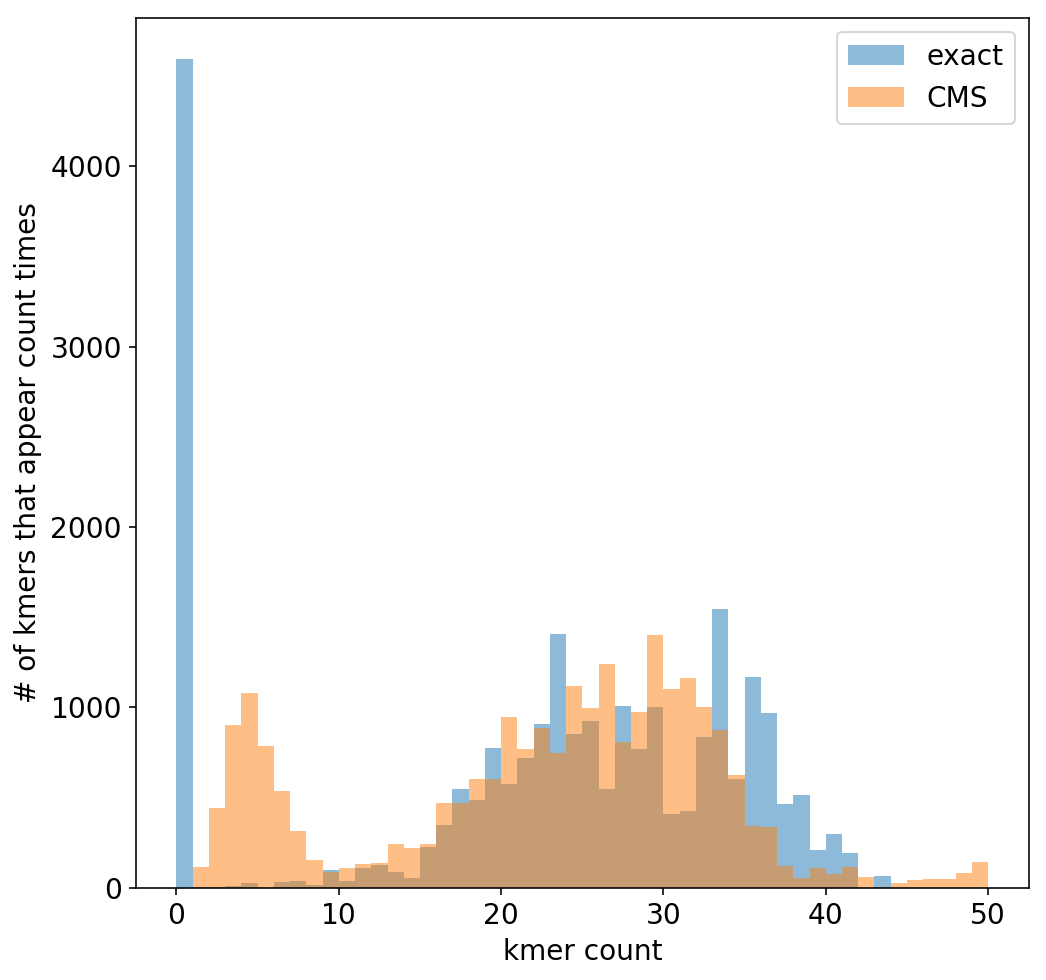

In [31]:
plt.hist([counts[kmer] for kmer in kmers(reads_with_errors)],
         range=(0,50), bins=50, label='exact',
         alpha=0.5)

cms_counts = [cm.query(kmer) for kmer in kmers(reads_with_errors)]
plt.hist(cms_counts, range=(0,50), bins=50, label='CMS',
         alpha=0.5)

plt.xlabel("kmer count")
plt.ylabel("# of kmers that appear count times")
plt.legend(loc='best');

---

## Coin flips

You can estimate the number of times someone flipped a coin by keeping track of the longest run of "heads":

In [32]:
def generate_coinflips(num):
    return [random.choice([0, 1]) for i in range(num)]

def longest_run_zero(x):
    i = 0
    count = 0
    max_count = 0
    while i < len(x):
        if x[i] == 0:
            count += 1
        else:
            if count > max_count:
                max_count = count
            count = 0
        i += 1
        
    return max_count


def longest_run_mc(flips, repeats):
    z = []
    for i in range(repeats):
        x = generate_coinflips(flips)
        count = longest_run_zero(x)
        z.append(count)
        
    return z

6.643856189774725


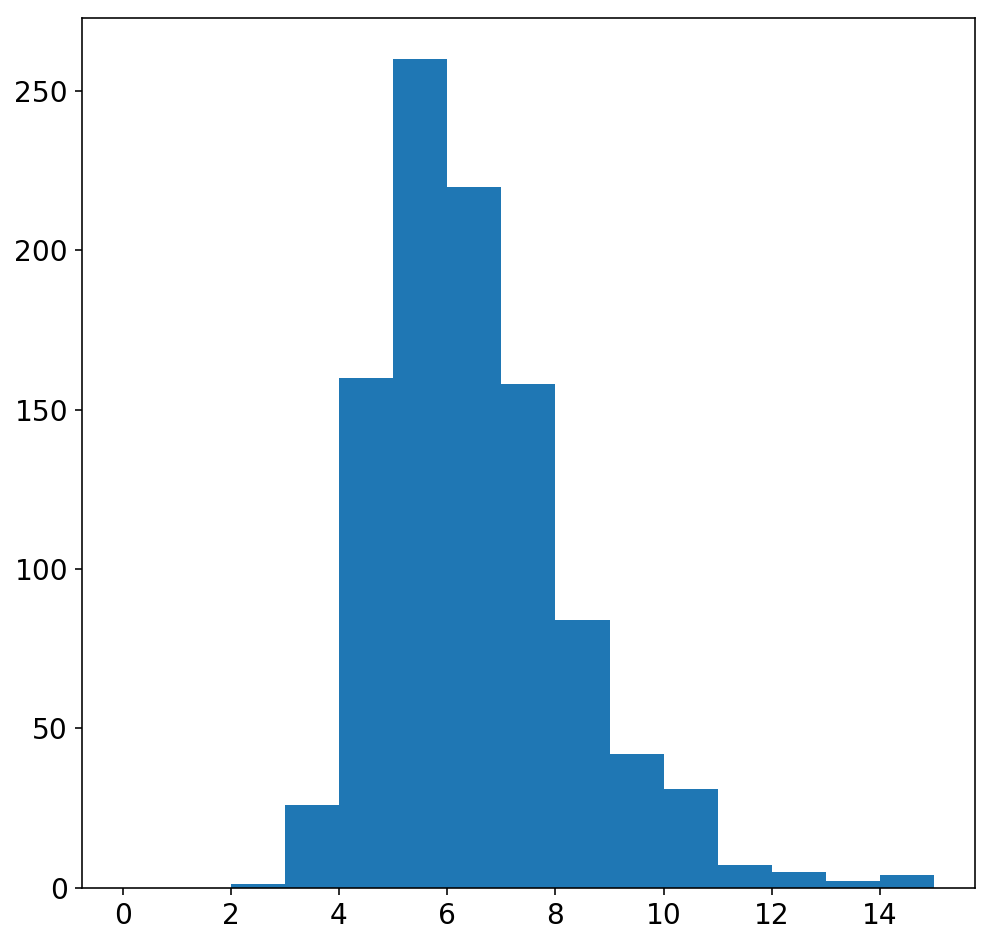

In [33]:
import math

d = longest_run_mc(100, 1000)
plt.hist(d, bins=max(d), range=(0, max(d)))

# we expect a peak right around...
print(math.log(100, 2))

8.965784284662087


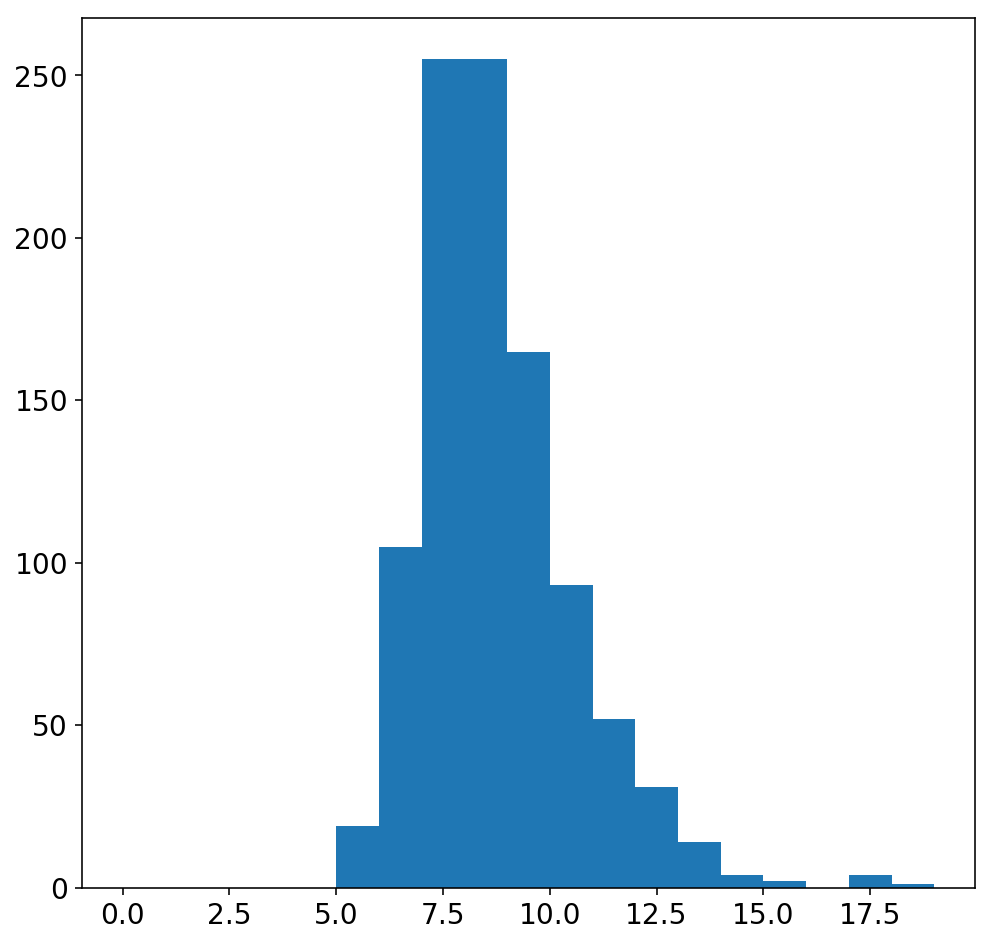

In [34]:
# flip 500 times in a row
d = longest_run_mc(500, 1000)
plt.hist(d, bins=max(d), range=(0, max(d)))

print(math.log(500, 2))

---

## Words in Shakespeare

How many unique words in Shakespeare?

In [35]:
words = []
with open("../data/pg100.txt") as f:
    for line in f:
        words.extend([w.strip() for w in line.split()])
    
len(set(words))

67780

In [36]:
def binary(w):
    """Binary representation of w"""
    return bin(w)[2:]

def rho(bit_string):
    """Index of first 1 in bit_string"""
    for n,x in enumerate(reversed(bit_string)):
        if x == '1':
            return n+1
        
    return 32

def alpha(b):
    if not (4 <= b <= 16):
        raise ValueError("b=%d should be in range [4 : 16]" % b)

    if b == 4:
        return 0.673

    if b == 5:
        return 0.697

    if b == 6:
        return 0.709

    return 0.7213 / (1.0 + 1.079 / (1 << b))

def hyperloglog(items, b=4):
    """Approximate count of distinct elements in `items`"""
    m = 2**b
    registers = np.zeros(m, dtype=np.uint8)

    for item in items:
        bin_ = binary(hash_(item))
        idx = int(bin_[-b:], 2)
        val = bin_[:-b]
        registers[idx] = max(registers[idx], rho(val))
     
    # original code
    z = sum(np.power(2, -float(reg)) for reg in registers)    
    E = alpha(b) * m**2 / z
    
    # correct for small values
    if E <= 2.5 * m:
        V = m - np.count_nonzero(registers)
        if V > 0:
            return m * np.log(m/float(V))
        else:
            return E
        
    # correct for very large values
    elif 1./30 * 2**32:
        return -2**32 * np.log(1 - E/2**32)
        
    return E

In [37]:
n_words = hyperloglog(words, 9)
print(n_words)

65711.0899801


In [38]:
# or about 3% error
(len(set(words)) - n_words) / len(set(words))

0.030523901149017957

---

# Scratch pad

Random exploration below here.

In [39]:
for i in range(len(reads[1])):
    b1 = reads[1][i]
    b2 = reads_with_errors[1][i]
    if b1 == b2:
        print(b1, b2)
    else:
        print(b1, b2, '*')

T T
C C
C C
T T
C C
T T
C C
A A
C G *
T T
C C
A A
T T
T T
A A
G G
T T
A A
C C
C C
T T
A A
G G
G G
A A
A A
G A *
G G
A A
T T
C C
G G
G G
T T
A A
T T
A A
C C
G G
G G
A A
A A
T T
G G
T T
C C
G G
T T
C C
C C
G G
A A
A A
A A
G G
T T
T T
G G
C C
C C
C C
A A
C C
C C
A A
C C
G G
G G
T T
G G
G G
C C
G G
A A
G G
G G
T T
G G
A A
T T
G G
A A
T T
C C
A A
A A
G G
A A
A A
T T
T T
C C
A A
T T
G G
C C
G G
C C
C C
C C


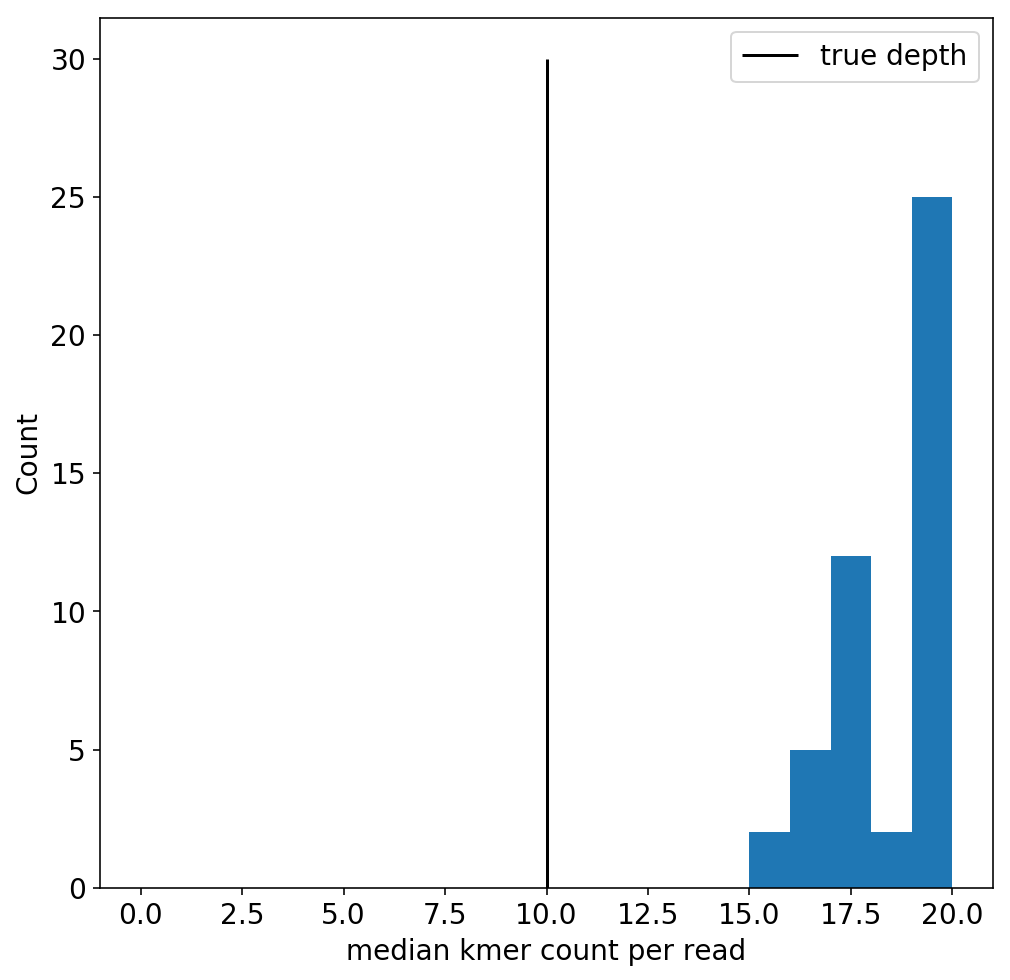

In [40]:
def plot_median_kmer_count(reads):
    counts = Counter(kmers(reads))
    medians = []
    for read in reads:
        kmer_counts = [counts[kmer] for kmer in kmers(read)]
        medians.append(np.median(kmer_counts))

    plt.hist(medians, bins=20, range=(0,20))
    plt.vlines(10, 0, 30, label='true depth')
    plt.legend(loc='best')
    plt.xlabel("median kmer count per read")
    plt.ylabel("Count");
    
plot_median_kmer_count(reads)

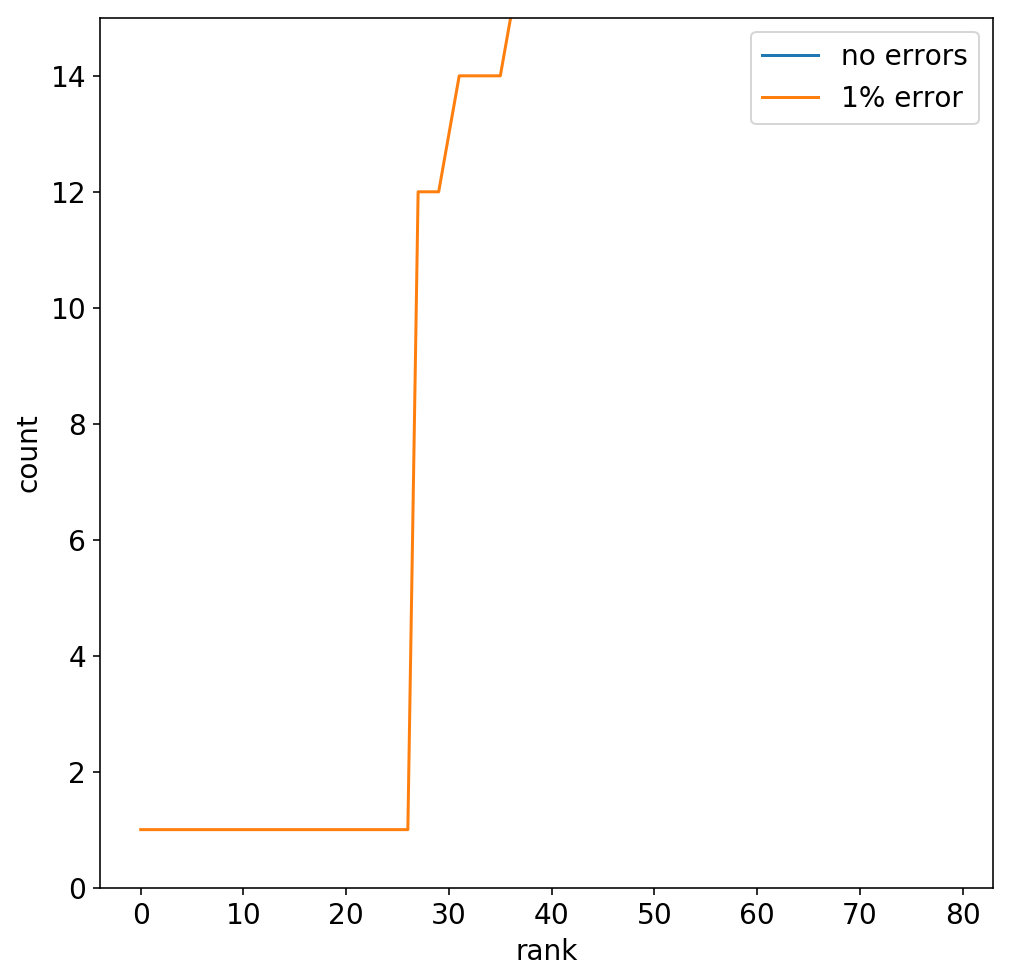

In [41]:
k_count = []
for kmer in kmers(reads[1]):
    k_count.append(counts[kmer])
    
k_count.sort()
plt.plot(k_count, label='no errors');

k_count = []
for kmer in kmers(reads_with_errors[1]):
    k_count.append(counts_with_errors[kmer])
    
k_count.sort()
plt.plot(k_count, label='1% error')
plt.xlabel('rank')
plt.ylabel('count')
plt.legend(loc='best')
plt.ylim([0, 15]);

---

## Real world genomics software

In [42]:
import khmer

In [43]:
ct = khmer.Counttable(21, 1000, 6)

In [44]:
for kmer in kmers(reads_with_errors):
    ct.add(kmer)

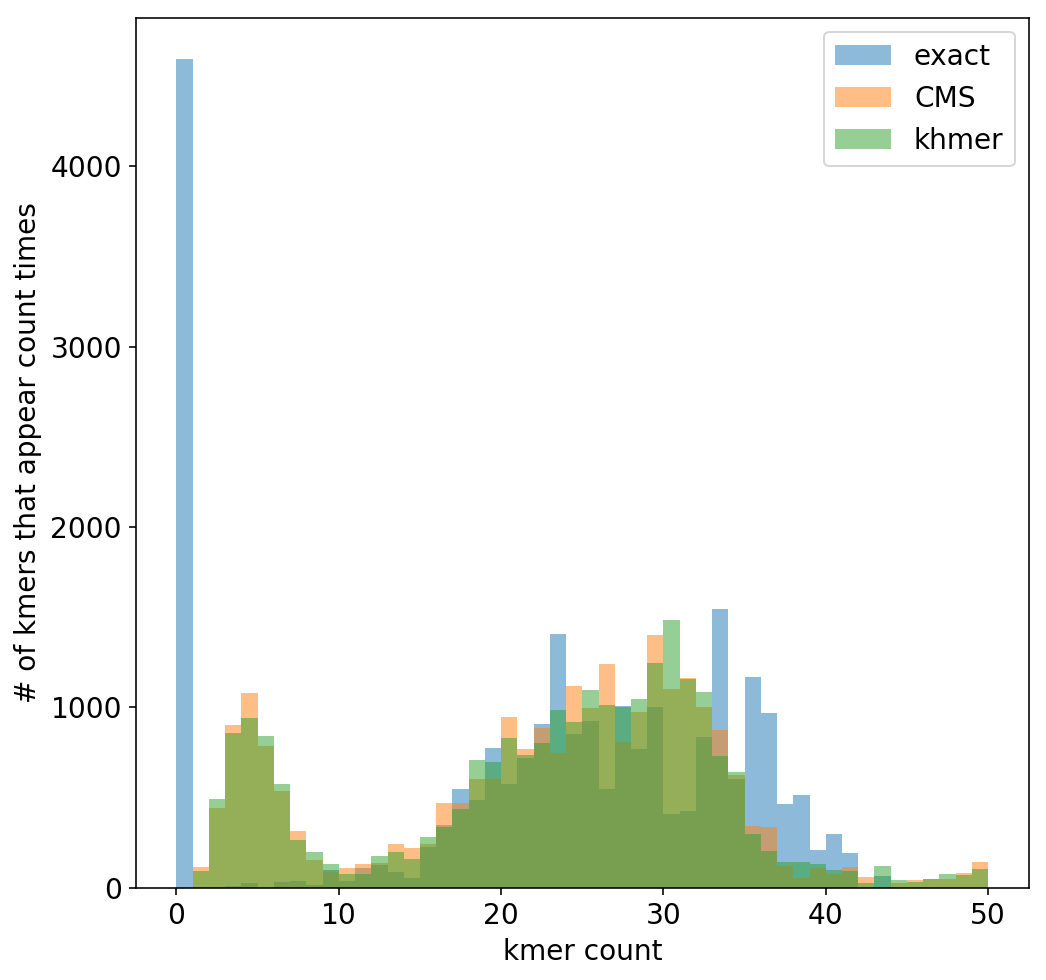

In [45]:
plt.hist([counts[kmer] for kmer in kmers(reads_with_errors)],
         range=(0,50), bins=50, label='exact',
         alpha=0.5)

cms_counts = [cm.query(kmer) for kmer in kmers(reads_with_errors)]
plt.hist(cms_counts, range=(0,50), bins=50, label='CMS',
         alpha=0.5)

ct_counts = [ct.get(kmer) for kmer in kmers(reads_with_errors)]
plt.hist(ct_counts, range=(0,50), bins=50, label='khmer',
         alpha=0.5)

plt.xlabel("kmer count")
plt.ylabel("# of kmers that appear count times")
plt.legend(loc='best');

In [46]:
a = np.zeros((2,3))

In [47]:
for i in range(a.shape[0]):
    for j in range(a.shape[1]):
        print(i,j, a[i,j])

0 0 0.0
0 1 0.0
0 2 0.0
1 0 0.0
1 1 0.0
1 2 0.0


In [48]:
plt.cm.autumn(24*2)[:3]

(1.0, 0.18823529411764706, 0.0)

In [49]:
np.max(a)

0.0